<a href="https://colab.research.google.com/github/safal207/hello-world/blob/master/NASNetLarge_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_tuberculosis%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Автоматическое определение туберкулеза по флюорографии

**Норма**|**Патология**
---|---
![X-Ray Normal](https://www.dropbox.com/s/b5nk171zefpb55m/normal.png?dl=1) | ![X-Ray Tuberculesis](https://www.dropbox.com/s/1t2mko52jjignhu/tuberculosis.png?dl=1)

Для обучения использован открыты набор данных [Pulmonary Chest X-Ray Abnormalities](https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities/home) на Kaggle. Исходные изображения были преобразованы к размеру 299х299 и распределены в каталоги по классам, как требует Keras. Ссылка на преобразованные изображения - https://www.dropbox.com/s/f64cvlhm0gp80v5/tuberculosis.zip?dl=1

Используется сеть Google InceptionV3, а также дополнение данных.

Чтобы запустить ноутбук, скопируйте его себе в Google Drive (меню File->Save a copy in Drive...).

При запуске желательно подключить GPU (меню Runtime -> Change runtime type -> Hardware Accelerator -> GPU), иначе сеть будет очень долго обучаться.

In [1]:
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Размер изображения
image_size = 299
# Размер мини-выборки
batch_size = 32

## Загружаем данные

In [3]:
!wget https://www.dropbox.com/s/f64cvlhm0gp80v5/tuberculosis.zip?dl=1 -O tuberculosis.zip

--2020-12-10 15:20:08--  https://www.dropbox.com/s/f64cvlhm0gp80v5/tuberculosis.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/f64cvlhm0gp80v5/tuberculosis.zip [following]
--2020-12-10 15:20:08--  https://www.dropbox.com/s/dl/f64cvlhm0gp80v5/tuberculosis.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc47dc737f65f784381a5eac9455.dl.dropboxusercontent.com/cd/0/get/BEyUNlbkHA2Mgg6SAvoKT21CMmEr2WAz9YMhBZEGHp8Gbklqf0N6UXTHmVSq-oJTMUiKbYqGuvZINWkxLpKlAoX9t-svft2G6s9qz-Lwxpv5Mg/file?dl=1# [following]
--2020-12-10 15:20:08--  https://uc47dc737f65f784381a5eac9455.dl.dropboxusercontent.com/cd/0/get/BEyUNlbkHA2Mgg6SAvoKT21CMmEr2WAz9YMhBZEGHp8Gbklqf0N6UXTHmVSq-oJTMUiKbYqGuvZINWkxLpKlAoX9t-svft2G6s9qz-Lwxpv5Mg/file?dl=1


In [4]:
!ls 

sample_data  tuberculosis.zip


In [5]:
!unzip tuberculosis.zip

Archive:  tuberculosis.zip
   creating: base_dir/
   creating: base_dir/train_dir/
   creating: base_dir/train_dir/Normal/
  inflating: base_dir/train_dir/Normal/CHNCXR_0001_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0002_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0003_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0004_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0005_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0006_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0007_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0008_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0009_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0011_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0012_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0013_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0014_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0015_0.png  
  inflating: base_dir/train_dir/Normal/CHNCXR_0016_

In [6]:
!ls base_dir/val_dir

Normal	Tuberculosis


## Просматриваем примеры данных

Нормальное изображение

In [7]:
!ls base_dir/train_dir/Normal/

CHNCXR_0001_0.png  CHNCXR_0101_0.png  CHNCXR_0207_0.png  CHNCXR_0311_0.png
CHNCXR_0002_0.png  CHNCXR_0102_0.png  CHNCXR_0208_0.png  CHNCXR_0312_0.png
CHNCXR_0003_0.png  CHNCXR_0103_0.png  CHNCXR_0209_0.png  CHNCXR_0313_0.png
CHNCXR_0004_0.png  CHNCXR_0105_0.png  CHNCXR_0210_0.png  CHNCXR_0314_0.png
CHNCXR_0005_0.png  CHNCXR_0106_0.png  CHNCXR_0211_0.png  CHNCXR_0315_0.png
CHNCXR_0006_0.png  CHNCXR_0107_0.png  CHNCXR_0214_0.png  CHNCXR_0316_0.png
CHNCXR_0007_0.png  CHNCXR_0109_0.png  CHNCXR_0215_0.png  CHNCXR_0317_0.png
CHNCXR_0008_0.png  CHNCXR_0110_0.png  CHNCXR_0216_0.png  CHNCXR_0318_0.png
CHNCXR_0009_0.png  CHNCXR_0111_0.png  CHNCXR_0217_0.png  CHNCXR_0319_0.png
CHNCXR_0011_0.png  CHNCXR_0112_0.png  CHNCXR_0218_0.png  CHNCXR_0320_0.png
CHNCXR_0012_0.png  CHNCXR_0113_0.png  CHNCXR_0219_0.png  CHNCXR_0321_0.png
CHNCXR_0013_0.png  CHNCXR_0114_0.png  CHNCXR_0220_0.png  CHNCXR_0322_0.png
CHNCXR_0014_0.png  CHNCXR_0115_0.png  CHNCXR_0221_0.png  CHNCXR_0323_0.png
CHNCXR_0015_0.png  CHNCXR

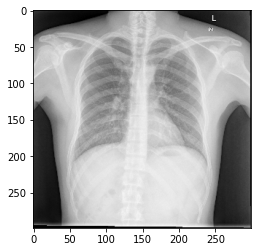

In [8]:
img_path = 'base_dir/train_dir/Normal/CHNCXR_0163_0.png'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

Туберкулез

In [9]:
!ls base_dir/train_dir/Tuberculosis

CHNCXR_0328_1.png  CHNCXR_0428_1.png  CHNCXR_0531_1.png  CHNCXR_0622_1.png
CHNCXR_0329_1.png  CHNCXR_0429_1.png  CHNCXR_0532_1.png  CHNCXR_0623_1.png
CHNCXR_0330_1.png  CHNCXR_0432_1.png  CHNCXR_0533_1.png  CHNCXR_0624_1.png
CHNCXR_0331_1.png  CHNCXR_0435_1.png  CHNCXR_0535_1.png  CHNCXR_0625_1.png
CHNCXR_0332_1.png  CHNCXR_0436_1.png  CHNCXR_0536_1.png  CHNCXR_0626_1.png
CHNCXR_0333_1.png  CHNCXR_0437_1.png  CHNCXR_0537_1.png  CHNCXR_0628_1.png
CHNCXR_0334_1.png  CHNCXR_0441_1.png  CHNCXR_0538_1.png  CHNCXR_0630_1.png
CHNCXR_0335_1.png  CHNCXR_0442_1.png  CHNCXR_0539_1.png  CHNCXR_0631_1.png
CHNCXR_0336_1.png  CHNCXR_0443_1.png  CHNCXR_0540_1.png  CHNCXR_0632_1.png
CHNCXR_0338_1.png  CHNCXR_0444_1.png  CHNCXR_0541_1.png  CHNCXR_0633_1.png
CHNCXR_0339_1.png  CHNCXR_0445_1.png  CHNCXR_0542_1.png  CHNCXR_0634_1.png
CHNCXR_0340_1.png  CHNCXR_0446_1.png  CHNCXR_0543_1.png  CHNCXR_0635_1.png
CHNCXR_0342_1.png  CHNCXR_0447_1.png  CHNCXR_0544_1.png  CHNCXR_0637_1.png
CHNCXR_0343_1.png  CHNCXR

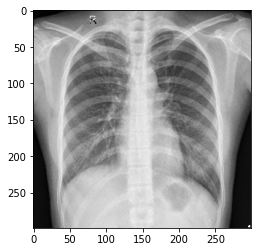

In [10]:
img_path = 'base_dir/train_dir/Tuberculosis/CHNCXR_0393_1.png'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

## Создаем генераторы изображений

In [12]:
# Каталог с данными для обучения
train_dir = 'base_dir/train_dir'
test_dir = 'base_dir/val_dir'
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (image_size, image_size, 3)

Генератор с дополнением данных (data augmentation)

In [13]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

Проверяем генератор

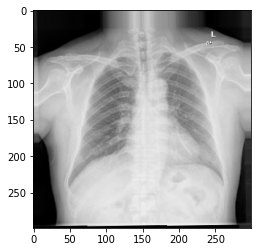

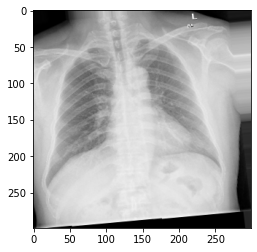

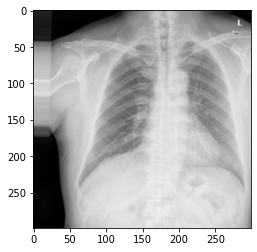

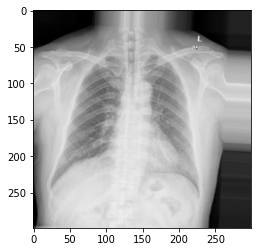

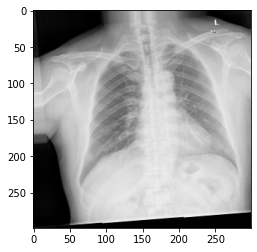

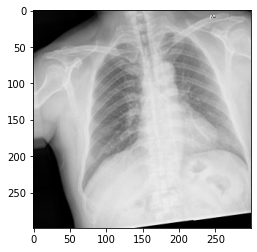

In [14]:
img_path = 'base_dir/train_dir/Normal/CHNCXR_0001_0.png'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Генератор для обучения

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 680 images belonging to 2 classes.


Генератор для тестирования без дополнения данных

In [16]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 120 images belonging to 2 classes.


Номера классов в генераторах

In [18]:
train_generator.class_indices

{'Normal': 0, 'Tuberculosis': 1}

## Загружаем предварительно обученную нейронную сеть Inception

In [19]:
pretrained_model = NASNetLarge(weights='imagenet', include_top=False)

343613440/343610240 [==============================] - 3s 0us/step


In [20]:
pretrained_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

"Замораживаем" веса предварительно обученной нейронной сети

In [21]:
pretrained_model.trainable = False

## Создаем составную нейронную сеть

In [22]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

## Обучаем составную нейронную сеть на основе NASNetLarge


In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [24]:
filepath="NASNetLarge_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [27]:
steps_per_epoch = 24
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=20,
    callbacks=callbacks_list,
    epochs=125,
    verbose=2)

Epoch 1/125
22/24 - 16s - loss: 0.5071 - accuracy: 0.7647


## Дообучение сверточных слоев NASNetLarge

Загружаем лучшие веса

In [29]:
model.load_weights("NASNetLarge_best.h5")

Размораживаем два последних блока Inception

In [30]:
pretrained_model.trainable = False
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

Компилируем сеть с размороженными слоями

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [32]:
filepath="NASNetLarge_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]

In [40]:
steps_per_epoch = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

Epoch 1/5

Epoch 00001: val_accuracy did not improve from 0.58333
10/10 - 16s - loss: 0.0584 - accuracy: 0.9781 - val_loss: 3.5755 - val_accuracy: 0.5250
Epoch 2/5
10/10 - 14s - loss: 0.0621 - accuracy: 0.9812
Epoch 3/5
10/10 - 14s - loss: 0.0356 - accuracy: 0.9906
Epoch 4/5


KeyboardInterrupt: ignored

## Тестируем модель

Загружаем обученные веса

In [41]:
model = load_model("NASNetLarge_fine_tuned.h5")

Загружаем изображение

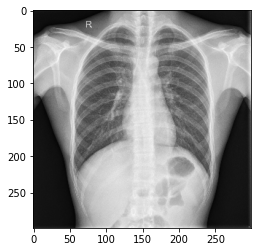

In [42]:
#img_path = 'base_dir/val_dir/Tuberculosis/CHNCXR_0337_1.png'
img_path = 'base_dir/val_dir/Normal/CHNCXR_0171_0.png'
#img_path = 'base_dir/val_dir/Tuberculosis/MCUCXR_0367_1.png'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив для распознавания

In [43]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [44]:
prediction = model.predict(x)

In [45]:
prediction

array([[0.3118931]], dtype=float32)

Метки классов: 

{'Normal': 0, 'Tuberculosis': 1}

In [46]:
if prediction[[0]] < 0.5:
    print('Normal')
else:
    print('Tuberculosis')

Normal
